In [1]:
import sys
import pickle
import matplotlib.pyplot as plt

from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/jupyter/gama/bruno')

from tqdm.notebook import tqdm

import numpy as np

In [2]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [3]:
import h5py

from torch.utils.data import Dataset
from torchvision import transforms


class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

val_data = ADNIDatasetForBraTSModel('/home/jupyter/data/ADNI/brats_2mm_preprocessed/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(val_data) / 40

561.0

In [4]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '1tz3p1dw').to(device)  # pre-trained, linear lr decay
net.eval()
net



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

In [5]:
from torch.utils.data import DataLoader

val_dataloader = DataLoader(val_data, batch_size=40, shuffle=False)

In [8]:
X, y = next(iter(val_dataloader))

X.shape

torch.Size([40, 1, 96, 96])

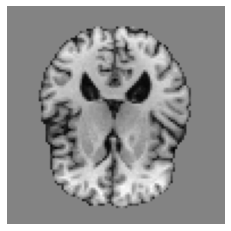

In [17]:
plt.imshow(X[20].squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [19]:
y_pred = net(X.to(device))
y_pred.shape

torch.Size([40])

In [ ]:
Y_pred = list()
Y = list()
for X, y in tqdm(val_dataloader):
    X, y = X.to(device), y.to(device)

    Y_pred.append(net(X).cpu().detach().numpy())
    Y.append(y.cpu().detach().numpy())

Y = np.stack(Y)
Y_pred = np.stack(Y_pred)